In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange

/Users/thrilok/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def plot_results(images,n_cols=None,title=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images=np.squeeze(images, axis =-1)
        
    fig = plt.figure(figsize=(n_cols,n_rows))
    
    for index,image in enumerate(images):
        plt.subplot(n_rows,n_cols,index + 1)
        plt.imshow(image,cmap="binary")
        plt.axis("off")
    
    plt.suptitle(title)


In [3]:
BATCH_SIZE = 128
CODINGS_SIZE = 32
N_EPOCHS = 150

In [4]:
def prepare_data(label, batch_size):
    (X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train,X_test])
    y_all = np.concatenate([y_train,y_test])
    
    X_all = X_all.astype(np.float32)/255
    X_all = X_all.reshape(-1,28,28,1)
    X_train = X_all[np.where(y_all == label)]
    
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE,drop_remainder=True).prefetch(1)
    return dataset

def prepare_images(label):
    (X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train,X_test])
    y_all = np.concatenate([y_train,y_test])
    
    X_all = X_all.astype(np.float32)/255
    X_all = X_all.reshape(-1,28,28,1) * 2. -1.
    X_train = X_all[np.where(y_all == label)]
    
    return X_train

In [5]:
class Sampling(keras.layers.Layer):
    
    def call(self,inputs):
        z_mean,z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
def build_encoder():
    encoder_inputs = keras.Input(shape=(28,28,1))
    x = keras.layers.Conv2D(32,3, activation="relu", strides=2,padding="same")(encoder_inputs)
    x = keras.layers.Conv2D(64,3,activation="relu",strides=2,padding="same")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    z_mean = keras.layers.Dense(CODINGS_SIZE, name="z_mean")(x)
    z_log_var = keras.layers.Dense(CODINGS_SIZE, name="z_log_var")(x)
    z = Sampling()([z_mean,z_log_var])
    encoder = keras.Model(encoder_inputs,[z_mean,z_log_var,z],name="encoder")
    return encoder

In [7]:
def build_decoder():
    latent_inputs = keras.Input(shape=(CODINGS_SIZE,))
    x = keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = keras.layers.Reshape((7,7,64))(x)
    x = keras.layers.Conv2DTranspose(64,3,activation="relu",strides=2,padding="same")(x)
    x = keras.layers.Conv2DTranspose(32,3,activation="relu",strides=2,padding="same")(x)
    decoder_outputs = keras.layers.Conv2DTranspose(1,3,activation="sigmoid",padding="same")(x)
    decoder = keras.Model(latent_inputs,decoder_outputs,name="decoder")
    return decoder

In [8]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder, **kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    def train_step(self,data):
        with tf.GradientTape() as Tape:
            z_mean,z_log_var,z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.math.reduce_sum(keras.losses.binary_crossentropy(data,reconstruction),axis=(1,2)))
            kl_loss = -0.5 * ( 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = Tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

2022-04-21 22:55:52.604771: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-21 22:55:52.604857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Encoder Summary


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________

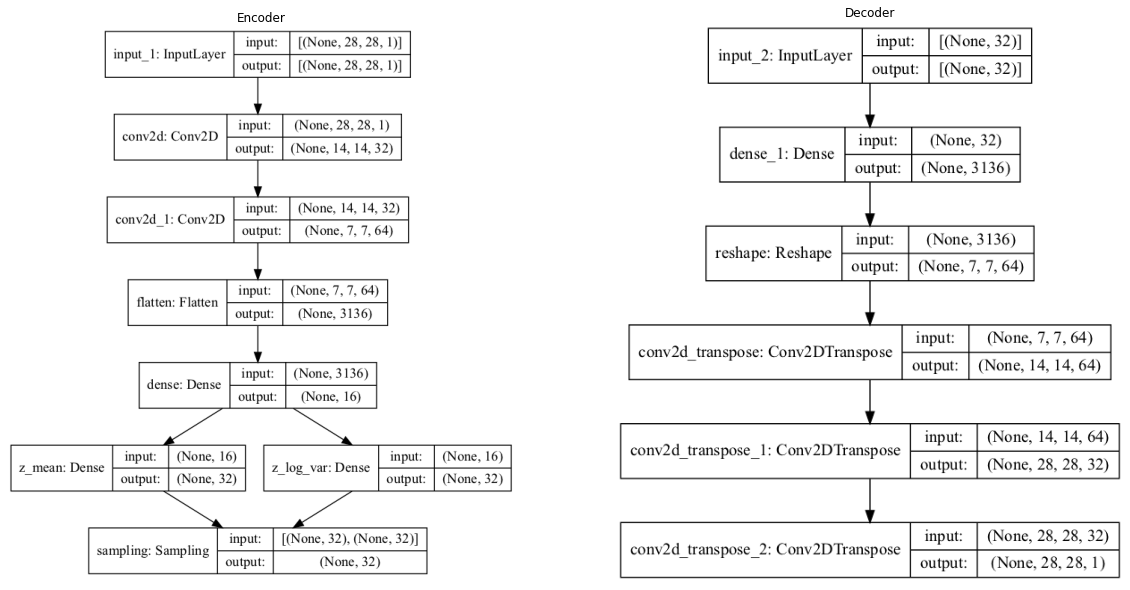

In [9]:
encoder = build_encoder()
decoder = build_decoder()
print('Encoder Summary\n\n')
encoder.summary()
print('\n\nDecoder Summary\n\n')
decoder.summary()
keras.utils.plot_model(encoder,show_shapes=True,expand_nested=True,to_file='encoder.png')
keras.utils.plot_model(decoder,show_shapes=True,expand_nested = True, to_file='decoder.png')
fig,ax = plt.subplots(1,2,figsize=(20,12))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder')
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder')
ax[0].axis("off")
ax[1].axis("off")
plt.show()

Epoch 1/150


2022-04-21 22:55:53.838558: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-21 22:55:53.839487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 5s 22ms/step - loss: 391.0959 - reconstruction_loss: 295.4567 - kl_loss: 0.9246
Epoch 2/150
53/53 [==============================] - 1s 22ms/step - loss: 213.4543 - reconstruction_loss: 208.2094 - kl_loss: 1.1086
Epoch 3/150
53/53 [==============================] - 1s 21ms/step - loss: 196.6577 - reconstruction_loss: 188.1565 - kl_loss: 1.5883
Epoch 4/150
53/53 [==============================] - 1s 22ms/step - loss: 170.6177 - reconstruction_loss: 159.4727 - kl_loss: 2.1700
Epoch 5/150
53/53 [==============================] - 1s 22ms/step - loss: 141.6135 - reconstruction_loss: 134.7124 - kl_loss: 2.5486
Epoch 6/150
53/53 [==============================] - 1s 22ms/step - loss: 126.2255 - reconstruction_loss: 120.3782 - kl_loss: 2.7710
Epoch 7/150
53/53 [==============================] - 1s 21ms/step - loss: 116.2384 - reconstruction_loss: 112.1887 - kl_loss: 2.7407
Epoch 8/150
53/53 [==============================] - 1s 21ms/step - loss: 112.619

53/53 [==============================] - 1s 21ms/step - loss: 88.6309 - reconstruction_loss: 86.0461 - kl_loss: 2.3740
Epoch 64/150
53/53 [==============================] - 1s 21ms/step - loss: 88.4182 - reconstruction_loss: 85.8988 - kl_loss: 2.3713
Epoch 65/150
53/53 [==============================] - 1s 21ms/step - loss: 88.3738 - reconstruction_loss: 85.7872 - kl_loss: 2.3624
Epoch 66/150
53/53 [==============================] - 1s 21ms/step - loss: 88.5195 - reconstruction_loss: 85.7461 - kl_loss: 2.3578
Epoch 67/150
53/53 [==============================] - 1s 21ms/step - loss: 88.3401 - reconstruction_loss: 85.6906 - kl_loss: 2.3567
Epoch 68/150
53/53 [==============================] - 1s 21ms/step - loss: 88.1841 - reconstruction_loss: 85.5895 - kl_loss: 2.3465
Epoch 69/150
53/53 [==============================] - 1s 21ms/step - loss: 88.0513 - reconstruction_loss: 85.6290 - kl_loss: 2.3500
Epoch 70/150
53/53 [==============================] - 1s 21ms/step - loss: 88.1038 - reco

Epoch 125/150
53/53 [==============================] - 1s 21ms/step - loss: 85.4475 - reconstruction_loss: 83.0564 - kl_loss: 2.1968
Epoch 126/150
53/53 [==============================] - 1s 21ms/step - loss: 85.2901 - reconstruction_loss: 83.0637 - kl_loss: 2.1938
Epoch 127/150
53/53 [==============================] - 1s 21ms/step - loss: 85.4594 - reconstruction_loss: 83.0106 - kl_loss: 2.1824
Epoch 128/150
53/53 [==============================] - 1s 21ms/step - loss: 85.3951 - reconstruction_loss: 82.9053 - kl_loss: 2.1839
Epoch 129/150
53/53 [==============================] - 1s 21ms/step - loss: 85.4044 - reconstruction_loss: 83.0114 - kl_loss: 2.1823
Epoch 130/150
53/53 [==============================] - 1s 21ms/step - loss: 85.2500 - reconstruction_loss: 82.9235 - kl_loss: 2.1734
Epoch 131/150
53/53 [==============================] - 1s 21ms/step - loss: 85.3378 - reconstruction_loss: 82.8731 - kl_loss: 2.1858
Epoch 132/150
53/53 [==============================] - 1s 21ms/step -

2022-04-21 22:58:48.988560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 2s 21ms/step - loss: 316.4369 - reconstruction_loss: 196.4298 - kl_loss: 0.6079
Epoch 2/150
61/61 [==============================] - 1s 21ms/step - loss: 104.9948 - reconstruction_loss: 96.1331 - kl_loss: 1.0706
Epoch 3/150
61/61 [==============================] - 1s 21ms/step - loss: 78.6840 - reconstruction_loss: 71.2891 - kl_loss: 1.8429
Epoch 4/150
61/61 [==============================] - 1s 21ms/step - loss: 63.0968 - reconstruction_loss: 58.1706 - kl_loss: 1.8812
Epoch 5/150
61/61 [==============================] - 1s 21ms/step - loss: 54.6628 - reconstruction_loss: 49.8498 - kl_loss: 1.9731
Epoch 6/150
61/61 [==============================] - 1s 21ms/step - loss: 48.2548 - reconstruction_loss: 44.6093 - kl_loss: 2.0223
Epoch 7/150
61/61 [==============================] - 1s 21ms/step - loss: 45.0406 - reconstruction_loss: 41.7521 - kl_loss: 2.1008
Epoch 8/150
61/61 [==============================] - 1s 21ms/step - loss: 42.8285 - reconstr

61/61 [==============================] - 1s 21ms/step - loss: 34.1967 - reconstruction_loss: 32.2683 - kl_loss: 1.5654
Epoch 64/150
61/61 [==============================] - 1s 21ms/step - loss: 34.0910 - reconstruction_loss: 32.2648 - kl_loss: 1.5498
Epoch 65/150
61/61 [==============================] - 1s 21ms/step - loss: 34.1316 - reconstruction_loss: 32.2319 - kl_loss: 1.5476
Epoch 66/150
61/61 [==============================] - 1s 21ms/step - loss: 34.1035 - reconstruction_loss: 32.1851 - kl_loss: 1.5353
Epoch 67/150
61/61 [==============================] - 1s 21ms/step - loss: 34.0402 - reconstruction_loss: 32.1740 - kl_loss: 1.5343
Epoch 68/150
61/61 [==============================] - 1s 21ms/step - loss: 33.9599 - reconstruction_loss: 32.1412 - kl_loss: 1.5368
Epoch 69/150
61/61 [==============================] - 1s 21ms/step - loss: 33.9028 - reconstruction_loss: 32.1526 - kl_loss: 1.5265
Epoch 70/150
61/61 [==============================] - 1s 21ms/step - loss: 33.9889 - reco

Epoch 125/150
61/61 [==============================] - 1s 21ms/step - loss: 32.6778 - reconstruction_loss: 31.0462 - kl_loss: 1.3688
Epoch 126/150
61/61 [==============================] - 1s 21ms/step - loss: 32.6528 - reconstruction_loss: 30.9984 - kl_loss: 1.3660
Epoch 127/150
61/61 [==============================] - 1s 21ms/step - loss: 32.6188 - reconstruction_loss: 30.9857 - kl_loss: 1.3651
Epoch 128/150
61/61 [==============================] - 1s 21ms/step - loss: 32.6101 - reconstruction_loss: 30.9845 - kl_loss: 1.3642
Epoch 129/150
61/61 [==============================] - 1s 21ms/step - loss: 32.5805 - reconstruction_loss: 30.9691 - kl_loss: 1.3615
Epoch 130/150
61/61 [==============================] - 1s 21ms/step - loss: 32.5195 - reconstruction_loss: 30.9094 - kl_loss: 1.3600
Epoch 131/150
61/61 [==============================] - 1s 21ms/step - loss: 32.5487 - reconstruction_loss: 30.9138 - kl_loss: 1.3587
Epoch 132/150
61/61 [==============================] - 1s 21ms/step -

2022-04-21 23:02:05.328220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 21ms/step - loss: 385.4729 - reconstruction_loss: 291.6293 - kl_loss: 0.6443
Epoch 2/150
54/54 [==============================] - 1s 21ms/step - loss: 210.8480 - reconstruction_loss: 208.3349 - kl_loss: 0.7825
Epoch 3/150
54/54 [==============================] - 1s 22ms/step - loss: 204.5201 - reconstruction_loss: 200.4479 - kl_loss: 1.0528
Epoch 4/150
54/54 [==============================] - 1s 22ms/step - loss: 190.7445 - reconstruction_loss: 186.7552 - kl_loss: 1.5625
Epoch 5/150
54/54 [==============================] - 1s 22ms/step - loss: 178.2469 - reconstruction_loss: 173.7725 - kl_loss: 1.9738
Epoch 6/150
54/54 [==============================] - 1s 22ms/step - loss: 168.6010 - reconstruction_loss: 163.6382 - kl_loss: 2.4021
Epoch 7/150
54/54 [==============================] - 1s 22ms/step - loss: 159.3487 - reconstruction_loss: 155.0941 - kl_loss: 2.5248
Epoch 8/150
54/54 [==============================] - 1s 22ms/step - loss: 153.815

54/54 [==============================] - 1s 24ms/step - loss: 128.2964 - reconstruction_loss: 125.9737 - kl_loss: 2.0779
Epoch 63/150
54/54 [==============================] - 1s 25ms/step - loss: 127.7993 - reconstruction_loss: 125.8537 - kl_loss: 2.0684
Epoch 64/150
54/54 [==============================] - 1s 26ms/step - loss: 128.0133 - reconstruction_loss: 125.8635 - kl_loss: 2.0653
Epoch 65/150
54/54 [==============================] - 1s 26ms/step - loss: 128.0505 - reconstruction_loss: 125.8345 - kl_loss: 2.0746
Epoch 66/150
54/54 [==============================] - 1s 26ms/step - loss: 127.7303 - reconstruction_loss: 125.6319 - kl_loss: 2.0775
Epoch 67/150
54/54 [==============================] - 1s 25ms/step - loss: 127.3745 - reconstruction_loss: 125.5667 - kl_loss: 2.0612
Epoch 68/150
54/54 [==============================] - 1s 25ms/step - loss: 127.5383 - reconstruction_loss: 125.5330 - kl_loss: 2.0697
Epoch 69/150
54/54 [==============================] - 1s 25ms/step - loss: 

54/54 [==============================] - 1s 25ms/step - loss: 124.2530 - reconstruction_loss: 122.2522 - kl_loss: 2.0318
Epoch 124/150
54/54 [==============================] - 1s 25ms/step - loss: 124.1742 - reconstruction_loss: 122.2772 - kl_loss: 2.0219
Epoch 125/150
54/54 [==============================] - 1s 25ms/step - loss: 124.1529 - reconstruction_loss: 122.0662 - kl_loss: 2.0259
Epoch 126/150
54/54 [==============================] - 1s 24ms/step - loss: 124.1864 - reconstruction_loss: 122.1253 - kl_loss: 2.0272
Epoch 127/150
54/54 [==============================] - 1s 24ms/step - loss: 124.1055 - reconstruction_loss: 122.0699 - kl_loss: 2.0255
Epoch 128/150
54/54 [==============================] - 1s 24ms/step - loss: 124.2273 - reconstruction_loss: 122.1661 - kl_loss: 2.0285
Epoch 129/150
54/54 [==============================] - 1s 25ms/step - loss: 124.0431 - reconstruction_loss: 121.9817 - kl_loss: 2.0311
Epoch 130/150
54/54 [==============================] - 1s 25ms/step -

2022-04-21 23:05:25.206253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 2s 24ms/step - loss: 377.5157 - reconstruction_loss: 279.0490 - kl_loss: 0.6976
Epoch 2/150
55/55 [==============================] - 1s 25ms/step - loss: 194.2637 - reconstruction_loss: 189.4274 - kl_loss: 1.0154
Epoch 3/150
55/55 [==============================] - 1s 26ms/step - loss: 178.8092 - reconstruction_loss: 172.5819 - kl_loss: 1.8042
Epoch 4/150
55/55 [==============================] - 2s 28ms/step - loss: 166.1178 - reconstruction_loss: 160.6804 - kl_loss: 1.8832
Epoch 5/150
55/55 [==============================] - 2s 28ms/step - loss: 153.3442 - reconstruction_loss: 146.3324 - kl_loss: 2.2351
Epoch 6/150
55/55 [==============================] - 1s 27ms/step - loss: 138.0067 - reconstruction_loss: 132.8466 - kl_loss: 2.6471
Epoch 7/150
55/55 [==============================] - 1s 26ms/step - loss: 130.4926 - reconstruction_loss: 126.7902 - kl_loss: 2.4825
Epoch 8/150
55/55 [==============================] - 1s 25ms/step - loss: 125.194

55/55 [==============================] - 2s 27ms/step - loss: 96.5298 - reconstruction_loss: 94.0746 - kl_loss: 2.4217
Epoch 63/150
55/55 [==============================] - 2s 28ms/step - loss: 96.1560 - reconstruction_loss: 93.9367 - kl_loss: 2.4055
Epoch 64/150
55/55 [==============================] - 2s 28ms/step - loss: 95.8685 - reconstruction_loss: 93.8835 - kl_loss: 2.3990
Epoch 65/150
55/55 [==============================] - 2s 29ms/step - loss: 95.8413 - reconstruction_loss: 93.7326 - kl_loss: 2.4201
Epoch 66/150
55/55 [==============================] - 2s 28ms/step - loss: 95.5775 - reconstruction_loss: 93.6677 - kl_loss: 2.4104
Epoch 67/150
55/55 [==============================] - 2s 28ms/step - loss: 95.7958 - reconstruction_loss: 93.7108 - kl_loss: 2.4165
Epoch 68/150
55/55 [==============================] - 2s 28ms/step - loss: 95.5945 - reconstruction_loss: 93.4496 - kl_loss: 2.4130
Epoch 69/150
55/55 [==============================] - 2s 28ms/step - loss: 95.3784 - reco

Epoch 124/150
55/55 [==============================] - 2s 29ms/step - loss: 90.5312 - reconstruction_loss: 88.5678 - kl_loss: 2.4489
Epoch 125/150
55/55 [==============================] - 2s 28ms/step - loss: 90.5878 - reconstruction_loss: 88.6683 - kl_loss: 2.4565
Epoch 126/150
55/55 [==============================] - 2s 29ms/step - loss: 90.5840 - reconstruction_loss: 88.5534 - kl_loss: 2.4546
Epoch 127/150
55/55 [==============================] - 2s 29ms/step - loss: 90.5971 - reconstruction_loss: 88.4329 - kl_loss: 2.4613
Epoch 128/150
55/55 [==============================] - 2s 28ms/step - loss: 90.4352 - reconstruction_loss: 88.3719 - kl_loss: 2.4605
Epoch 129/150
55/55 [==============================] - 2s 29ms/step - loss: 90.2367 - reconstruction_loss: 88.2099 - kl_loss: 2.4671
Epoch 130/150
55/55 [==============================] - 2s 29ms/step - loss: 90.4723 - reconstruction_loss: 88.1994 - kl_loss: 2.4597
Epoch 131/150
55/55 [==============================] - 2s 28ms/step -

2022-04-21 23:09:21.415436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 2s 26ms/step - loss: 369.1755 - reconstruction_loss: 267.0529 - kl_loss: 0.5155
Epoch 2/150
53/53 [==============================] - 1s 28ms/step - loss: 184.0368 - reconstruction_loss: 179.6660 - kl_loss: 0.7423
Epoch 3/150
53/53 [==============================] - 2s 30ms/step - loss: 174.4928 - reconstruction_loss: 169.0775 - kl_loss: 1.1087
Epoch 4/150
53/53 [==============================] - 2s 32ms/step - loss: 157.7899 - reconstruction_loss: 150.4100 - kl_loss: 1.9072
Epoch 5/150
53/53 [==============================] - 2s 30ms/step - loss: 142.4000 - reconstruction_loss: 137.1474 - kl_loss: 2.3388
Epoch 6/150
53/53 [==============================] - 2s 29ms/step - loss: 134.2227 - reconstruction_loss: 129.8896 - kl_loss: 2.3257
Epoch 7/150
53/53 [==============================] - 2s 29ms/step - loss: 127.6011 - reconstruction_loss: 123.2061 - kl_loss: 2.4921
Epoch 8/150
53/53 [==============================] - 2s 28ms/step - loss: 122.429

53/53 [==============================] - 2s 40ms/step - loss: 100.6220 - reconstruction_loss: 98.9356 - kl_loss: 1.8814
Epoch 63/150
53/53 [==============================] - 2s 38ms/step - loss: 100.8506 - reconstruction_loss: 98.9432 - kl_loss: 1.8738
Epoch 64/150
53/53 [==============================] - 2s 40ms/step - loss: 100.9442 - reconstruction_loss: 98.9159 - kl_loss: 1.8679
Epoch 65/150
53/53 [==============================] - 2s 36ms/step - loss: 100.9593 - reconstruction_loss: 98.8111 - kl_loss: 1.8737
Epoch 66/150
53/53 [==============================] - 2s 33ms/step - loss: 100.9275 - reconstruction_loss: 98.8685 - kl_loss: 1.8719
Epoch 67/150
53/53 [==============================] - 2s 32ms/step - loss: 100.6393 - reconstruction_loss: 98.7470 - kl_loss: 1.8686
Epoch 68/150
53/53 [==============================] - 2s 34ms/step - loss: 100.7185 - reconstruction_loss: 98.7305 - kl_loss: 1.8686
Epoch 69/150
53/53 [==============================] - 2s 36ms/step - loss: 100.664

53/53 [==============================] - 2s 31ms/step - loss: 98.5913 - reconstruction_loss: 96.7321 - kl_loss: 1.7626
Epoch 124/150
53/53 [==============================] - 2s 31ms/step - loss: 98.5515 - reconstruction_loss: 96.6640 - kl_loss: 1.7437
Epoch 125/150
53/53 [==============================] - 2s 32ms/step - loss: 98.3356 - reconstruction_loss: 96.6323 - kl_loss: 1.7651
Epoch 126/150
53/53 [==============================] - 2s 34ms/step - loss: 98.6171 - reconstruction_loss: 96.6447 - kl_loss: 1.7589
Epoch 127/150
53/53 [==============================] - 2s 34ms/step - loss: 98.4938 - reconstruction_loss: 96.4809 - kl_loss: 1.7595
Epoch 128/150
53/53 [==============================] - 2s 34ms/step - loss: 98.4582 - reconstruction_loss: 96.6023 - kl_loss: 1.7580
Epoch 129/150
53/53 [==============================] - 2s 33ms/step - loss: 98.3711 - reconstruction_loss: 96.4940 - kl_loss: 1.7508
Epoch 130/150
53/53 [==============================] - 2s 33ms/step - loss: 98.2323

2022-04-21 23:13:37.722066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 2s 27ms/step - loss: 386.7829 - reconstruction_loss: 288.6801 - kl_loss: 0.5599
Epoch 2/150
49/49 [==============================] - 1s 29ms/step - loss: 198.4848 - reconstruction_loss: 195.3632 - kl_loss: 0.8591
Epoch 3/150
49/49 [==============================] - 2s 33ms/step - loss: 181.3283 - reconstruction_loss: 175.8528 - kl_loss: 1.4093
Epoch 4/150
49/49 [==============================] - 2s 36ms/step - loss: 166.3120 - reconstruction_loss: 163.3919 - kl_loss: 1.6813
Epoch 5/150
49/49 [==============================] - 2s 36ms/step - loss: 156.4486 - reconstruction_loss: 153.0815 - kl_loss: 2.0102
Epoch 6/150
49/49 [==============================] - 2s 34ms/step - loss: 143.1415 - reconstruction_loss: 137.6855 - kl_loss: 2.7369
Epoch 7/150
49/49 [==============================] - 2s 31ms/step - loss: 131.5063 - reconstruction_loss: 128.7695 - kl_loss: 2.7539
Epoch 8/150
49/49 [==============================] - 1s 29ms/step - loss: 125.956

49/49 [==============================] - 2s 35ms/step - loss: 98.8996 - reconstruction_loss: 98.0720 - kl_loss: 2.2172
Epoch 63/150
49/49 [==============================] - 2s 34ms/step - loss: 99.1133 - reconstruction_loss: 98.0936 - kl_loss: 2.2075
Epoch 64/150
49/49 [==============================] - 2s 33ms/step - loss: 99.1484 - reconstruction_loss: 98.0303 - kl_loss: 2.2156
Epoch 65/150
49/49 [==============================] - 2s 32ms/step - loss: 99.1363 - reconstruction_loss: 97.9462 - kl_loss: 2.2066
Epoch 66/150
49/49 [==============================] - 2s 33ms/step - loss: 98.8511 - reconstruction_loss: 97.8908 - kl_loss: 2.2214
Epoch 67/150
49/49 [==============================] - 2s 36ms/step - loss: 98.8300 - reconstruction_loss: 97.6348 - kl_loss: 2.2284
Epoch 68/150
49/49 [==============================] - 2s 37ms/step - loss: 98.5301 - reconstruction_loss: 97.5429 - kl_loss: 2.2106
Epoch 69/150
49/49 [==============================] - 2s 37ms/step - loss: 98.7463 - reco

Epoch 124/150
49/49 [==============================] - 2s 32ms/step - loss: 94.7887 - reconstruction_loss: 94.0096 - kl_loss: 2.1493
Epoch 125/150
49/49 [==============================] - 2s 31ms/step - loss: 94.8311 - reconstruction_loss: 94.0031 - kl_loss: 2.1420
Epoch 126/150
49/49 [==============================] - 1s 30ms/step - loss: 95.3865 - reconstruction_loss: 93.9690 - kl_loss: 2.1573
Epoch 127/150
49/49 [==============================] - 2s 31ms/step - loss: 95.1175 - reconstruction_loss: 93.8362 - kl_loss: 2.1574
Epoch 128/150
49/49 [==============================] - 2s 31ms/step - loss: 95.0108 - reconstruction_loss: 93.7450 - kl_loss: 2.1560
Epoch 129/150
49/49 [==============================] - 2s 32ms/step - loss: 95.0326 - reconstruction_loss: 93.8676 - kl_loss: 2.1565
Epoch 130/150
49/49 [==============================] - 2s 31ms/step - loss: 94.6594 - reconstruction_loss: 93.6667 - kl_loss: 2.1534
Epoch 131/150
49/49 [==============================] - 2s 31ms/step -

2022-04-21 23:17:52.776580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 2s 27ms/step - loss: 375.2110 - reconstruction_loss: 274.3057 - kl_loss: 0.7064
Epoch 2/150
53/53 [==============================] - 2s 29ms/step - loss: 181.9256 - reconstruction_loss: 175.8782 - kl_loss: 1.3832
Epoch 3/150
53/53 [==============================] - 2s 33ms/step - loss: 160.1579 - reconstruction_loss: 155.2861 - kl_loss: 2.0646
Epoch 4/150
53/53 [==============================] - 2s 35ms/step - loss: 144.6898 - reconstruction_loss: 138.3001 - kl_loss: 2.4622
Epoch 5/150
53/53 [==============================] - 2s 33ms/step - loss: 131.3356 - reconstruction_loss: 127.7178 - kl_loss: 2.4222
Epoch 6/150
53/53 [==============================] - 2s 30ms/step - loss: 126.6030 - reconstruction_loss: 123.4324 - kl_loss: 2.2525
Epoch 7/150
53/53 [==============================] - 2s 29ms/step - loss: 122.3141 - reconstruction_loss: 118.7553 - kl_loss: 2.2396
Epoch 8/150
53/53 [==============================] - 2s 29ms/step - loss: 115.619

53/53 [==============================] - 2s 32ms/step - loss: 82.3549 - reconstruction_loss: 80.4469 - kl_loss: 2.2189
Epoch 64/150
53/53 [==============================] - 2s 32ms/step - loss: 82.1737 - reconstruction_loss: 80.4426 - kl_loss: 2.2202
Epoch 65/150
53/53 [==============================] - 2s 32ms/step - loss: 82.2192 - reconstruction_loss: 80.3573 - kl_loss: 2.2181
Epoch 66/150
53/53 [==============================] - 2s 31ms/step - loss: 82.0469 - reconstruction_loss: 80.2325 - kl_loss: 2.2050
Epoch 67/150
53/53 [==============================] - 2s 31ms/step - loss: 82.0203 - reconstruction_loss: 80.2963 - kl_loss: 2.2100
Epoch 68/150
53/53 [==============================] - 2s 31ms/step - loss: 82.0688 - reconstruction_loss: 80.1854 - kl_loss: 2.2076
Epoch 69/150
53/53 [==============================] - 2s 31ms/step - loss: 82.3144 - reconstruction_loss: 80.3052 - kl_loss: 2.2027
Epoch 70/150
53/53 [==============================] - 2s 32ms/step - loss: 81.9075 - reco

Epoch 125/150
53/53 [==============================] - 2s 33ms/step - loss: 79.5681 - reconstruction_loss: 77.8770 - kl_loss: 1.9844
Epoch 126/150
53/53 [==============================] - 2s 32ms/step - loss: 79.3330 - reconstruction_loss: 77.9361 - kl_loss: 1.9852
Epoch 127/150
53/53 [==============================] - 2s 31ms/step - loss: 79.4656 - reconstruction_loss: 77.9425 - kl_loss: 1.9733
Epoch 128/150
53/53 [==============================] - 2s 29ms/step - loss: 79.4389 - reconstruction_loss: 77.8118 - kl_loss: 1.9775
Epoch 129/150
53/53 [==============================] - 2s 29ms/step - loss: 79.4382 - reconstruction_loss: 77.8123 - kl_loss: 1.9676
Epoch 130/150
53/53 [==============================] - 2s 29ms/step - loss: 79.1286 - reconstruction_loss: 77.8496 - kl_loss: 1.9762
Epoch 131/150
53/53 [==============================] - 2s 29ms/step - loss: 79.4695 - reconstruction_loss: 77.6915 - kl_loss: 1.9827
Epoch 132/150
53/53 [==============================] - 2s 30ms/step -

2022-04-21 23:22:12.856440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 2s 27ms/step - loss: 356.6143 - reconstruction_loss: 250.4720 - kl_loss: 0.6493
Epoch 2/150
56/56 [==============================] - 2s 29ms/step - loss: 165.7102 - reconstruction_loss: 159.3058 - kl_loss: 1.0283
Epoch 3/150
56/56 [==============================] - 2s 32ms/step - loss: 144.4146 - reconstruction_loss: 137.2253 - kl_loss: 1.8831
Epoch 4/150
56/56 [==============================] - 2s 33ms/step - loss: 126.2501 - reconstruction_loss: 119.4607 - kl_loss: 2.3789
Epoch 5/150
56/56 [==============================] - 2s 32ms/step - loss: 112.5252 - reconstruction_loss: 106.4114 - kl_loss: 2.3821
Epoch 6/150
56/56 [==============================] - 2s 29ms/step - loss: 100.9942 - reconstruction_loss: 96.2345 - kl_loss: 2.5577
Epoch 7/150
56/56 [==============================] - 2s 29ms/step - loss: 94.5159 - reconstruction_loss: 90.3346 - kl_loss: 2.5106
Epoch 8/150
56/56 [==============================] - 2s 28ms/step - loss: 90.3407 - 

56/56 [==============================] - 2s 32ms/step - loss: 61.9628 - reconstruction_loss: 59.3524 - kl_loss: 2.4706
Epoch 64/150
56/56 [==============================] - 2s 31ms/step - loss: 61.6723 - reconstruction_loss: 59.2595 - kl_loss: 2.4653
Epoch 65/150
56/56 [==============================] - 2s 30ms/step - loss: 61.5557 - reconstruction_loss: 59.0687 - kl_loss: 2.4560
Epoch 66/150
56/56 [==============================] - 2s 29ms/step - loss: 61.5419 - reconstruction_loss: 59.1592 - kl_loss: 2.4552
Epoch 67/150
56/56 [==============================] - 2s 29ms/step - loss: 61.6760 - reconstruction_loss: 59.0496 - kl_loss: 2.4489
Epoch 68/150
56/56 [==============================] - 2s 29ms/step - loss: 61.3548 - reconstruction_loss: 58.9218 - kl_loss: 2.4673
Epoch 69/150
56/56 [==============================] - 2s 29ms/step - loss: 61.1651 - reconstruction_loss: 58.7848 - kl_loss: 2.4615
Epoch 70/150
56/56 [==============================] - 2s 29ms/step - loss: 61.2555 - reco

Epoch 125/150
56/56 [==============================] - 2s 32ms/step - loss: 58.4010 - reconstruction_loss: 56.1092 - kl_loss: 2.3688
Epoch 126/150
56/56 [==============================] - 2s 32ms/step - loss: 58.3563 - reconstruction_loss: 56.1200 - kl_loss: 2.3637
Epoch 127/150
56/56 [==============================] - 2s 32ms/step - loss: 58.4204 - reconstruction_loss: 56.0816 - kl_loss: 2.3669
Epoch 128/150
56/56 [==============================] - 2s 34ms/step - loss: 58.4151 - reconstruction_loss: 56.0305 - kl_loss: 2.3572
Epoch 129/150
56/56 [==============================] - 2s 36ms/step - loss: 58.2614 - reconstruction_loss: 55.9345 - kl_loss: 2.3597
Epoch 130/150
56/56 [==============================] - 2s 34ms/step - loss: 58.3089 - reconstruction_loss: 55.9891 - kl_loss: 2.3501
Epoch 131/150
56/56 [==============================] - 2s 39ms/step - loss: 58.1680 - reconstruction_loss: 55.9599 - kl_loss: 2.3474
Epoch 132/150
56/56 [==============================] - 2s 38ms/step -

2022-04-21 23:26:38.280658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 2s 28ms/step - loss: 382.9952 - reconstruction_loss: 284.3592 - kl_loss: 0.6994
Epoch 2/150
53/53 [==============================] - 2s 29ms/step - loss: 199.9973 - reconstruction_loss: 195.8025 - kl_loss: 0.9925
Epoch 3/150
53/53 [==============================] - 2s 32ms/step - loss: 189.4708 - reconstruction_loss: 183.3276 - kl_loss: 1.6508
Epoch 4/150
53/53 [==============================] - 2s 33ms/step - loss: 172.4390 - reconstruction_loss: 167.8216 - kl_loss: 1.9652
Epoch 5/150
53/53 [==============================] - 2s 32ms/step - loss: 158.1795 - reconstruction_loss: 152.1858 - kl_loss: 2.1159
Epoch 6/150
53/53 [==============================] - 2s 29ms/step - loss: 144.7296 - reconstruction_loss: 141.2437 - kl_loss: 2.1396
Epoch 7/150
53/53 [==============================] - 2s 29ms/step - loss: 138.6701 - reconstruction_loss: 135.1426 - kl_loss: 2.2120
Epoch 8/150
53/53 [==============================] - 2s 29ms/step - loss: 132.442

53/53 [==============================] - 2s 33ms/step - loss: 100.5154 - reconstruction_loss: 98.3211 - kl_loss: 2.5546
Epoch 63/150
53/53 [==============================] - 2s 32ms/step - loss: 99.9737 - reconstruction_loss: 98.2631 - kl_loss: 2.5361
Epoch 64/150
53/53 [==============================] - 2s 31ms/step - loss: 100.1179 - reconstruction_loss: 98.1752 - kl_loss: 2.5476
Epoch 65/150
53/53 [==============================] - 2s 29ms/step - loss: 100.1037 - reconstruction_loss: 98.1597 - kl_loss: 2.5356
Epoch 66/150
53/53 [==============================] - 2s 29ms/step - loss: 100.0937 - reconstruction_loss: 97.9571 - kl_loss: 2.5317
Epoch 67/150
53/53 [==============================] - 2s 29ms/step - loss: 99.8992 - reconstruction_loss: 98.0214 - kl_loss: 2.5262
Epoch 68/150
53/53 [==============================] - 2s 30ms/step - loss: 99.8552 - reconstruction_loss: 97.8489 - kl_loss: 2.5339
Epoch 69/150
53/53 [==============================] - 2s 31ms/step - loss: 99.6673 - 

53/53 [==============================] - 2s 33ms/step - loss: 96.1070 - reconstruction_loss: 94.2345 - kl_loss: 2.4438
Epoch 124/150
53/53 [==============================] - 2s 32ms/step - loss: 96.1773 - reconstruction_loss: 94.2198 - kl_loss: 2.4385
Epoch 125/150
53/53 [==============================] - 2s 31ms/step - loss: 96.0762 - reconstruction_loss: 94.2277 - kl_loss: 2.4224
Epoch 126/150
53/53 [==============================] - 2s 30ms/step - loss: 95.7235 - reconstruction_loss: 94.1943 - kl_loss: 2.4340
Epoch 127/150
53/53 [==============================] - 2s 29ms/step - loss: 95.9858 - reconstruction_loss: 94.1328 - kl_loss: 2.4218
Epoch 128/150
53/53 [==============================] - 2s 29ms/step - loss: 95.9479 - reconstruction_loss: 94.2298 - kl_loss: 2.4153
Epoch 129/150
53/53 [==============================] - 2s 30ms/step - loss: 96.1254 - reconstruction_loss: 94.2051 - kl_loss: 2.4261
Epoch 130/150
53/53 [==============================] - 2s 30ms/step - loss: 95.7285

2022-04-21 23:30:52.493820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 27ms/step - loss: 362.3890 - reconstruction_loss: 256.8849 - kl_loss: 0.6598
Epoch 2/150
54/54 [==============================] - 2s 30ms/step - loss: 171.1849 - reconstruction_loss: 166.1096 - kl_loss: 1.1391
Epoch 3/150
54/54 [==============================] - 2s 32ms/step - loss: 154.0153 - reconstruction_loss: 146.8482 - kl_loss: 2.0014
Epoch 4/150
54/54 [==============================] - 2s 33ms/step - loss: 138.4777 - reconstruction_loss: 132.2569 - kl_loss: 2.0930
Epoch 5/150
54/54 [==============================] - 2s 30ms/step - loss: 122.8710 - reconstruction_loss: 118.5597 - kl_loss: 2.2048
Epoch 6/150
54/54 [==============================] - 2s 29ms/step - loss: 115.5895 - reconstruction_loss: 111.6420 - kl_loss: 2.3119
Epoch 7/150
54/54 [==============================] - 2s 29ms/step - loss: 110.1628 - reconstruction_loss: 107.1798 - kl_loss: 2.2462
Epoch 8/150
54/54 [==============================] - 2s 29ms/step - loss: 106.077

54/54 [==============================] - 2s 32ms/step - loss: 77.5576 - reconstruction_loss: 75.6311 - kl_loss: 2.1596
Epoch 64/150
54/54 [==============================] - 2s 30ms/step - loss: 77.5507 - reconstruction_loss: 75.6601 - kl_loss: 2.1590
Epoch 65/150
54/54 [==============================] - 2s 29ms/step - loss: 77.6909 - reconstruction_loss: 75.6410 - kl_loss: 2.1475
Epoch 66/150
54/54 [==============================] - 2s 29ms/step - loss: 77.6496 - reconstruction_loss: 75.7547 - kl_loss: 2.1432
Epoch 67/150
54/54 [==============================] - 2s 28ms/step - loss: 77.4791 - reconstruction_loss: 75.4978 - kl_loss: 2.1468
Epoch 68/150
54/54 [==============================] - 2s 28ms/step - loss: 77.3340 - reconstruction_loss: 75.3940 - kl_loss: 2.1329
Epoch 69/150
54/54 [==============================] - 2s 29ms/step - loss: 77.2551 - reconstruction_loss: 75.3985 - kl_loss: 2.1455
Epoch 70/150
54/54 [==============================] - 2s 29ms/step - loss: 77.2348 - reco

Epoch 125/150
54/54 [==============================] - 2s 30ms/step - loss: 75.0464 - reconstruction_loss: 73.3917 - kl_loss: 1.9275
Epoch 126/150
54/54 [==============================] - 2s 29ms/step - loss: 74.8761 - reconstruction_loss: 73.4352 - kl_loss: 1.9160
Epoch 127/150
54/54 [==============================] - 2s 29ms/step - loss: 74.9009 - reconstruction_loss: 73.3532 - kl_loss: 1.9186
Epoch 128/150
54/54 [==============================] - 2s 29ms/step - loss: 74.7948 - reconstruction_loss: 73.3218 - kl_loss: 1.9064
Epoch 129/150
54/54 [==============================] - 2s 29ms/step - loss: 74.8306 - reconstruction_loss: 73.2671 - kl_loss: 1.9159
Epoch 130/150
54/54 [==============================] - 2s 29ms/step - loss: 74.8827 - reconstruction_loss: 73.2386 - kl_loss: 1.9080
Epoch 131/150
54/54 [==============================] - 2s 29ms/step - loss: 74.7359 - reconstruction_loss: 73.2808 - kl_loss: 1.8998
Epoch 132/150
54/54 [==============================] - 2s 29ms/step -

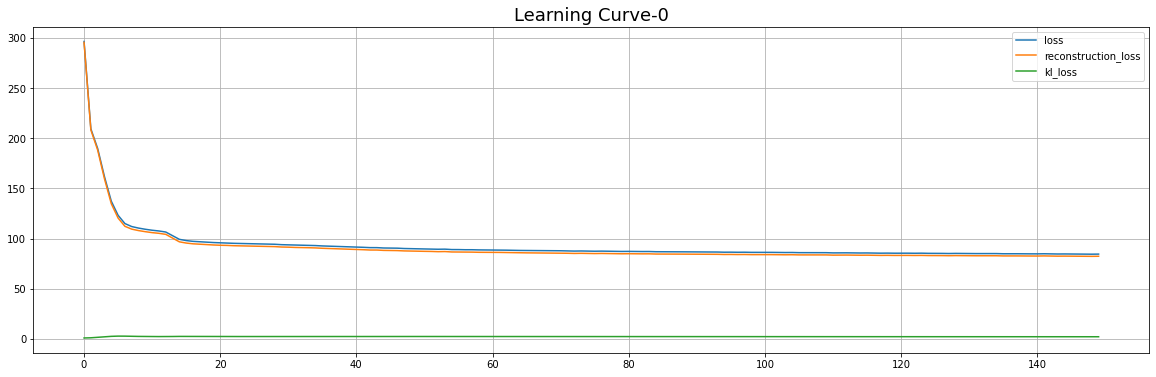

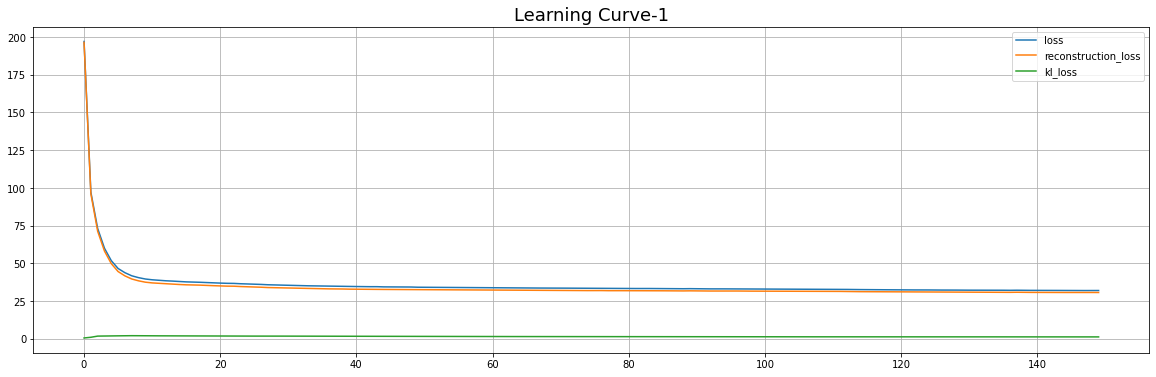

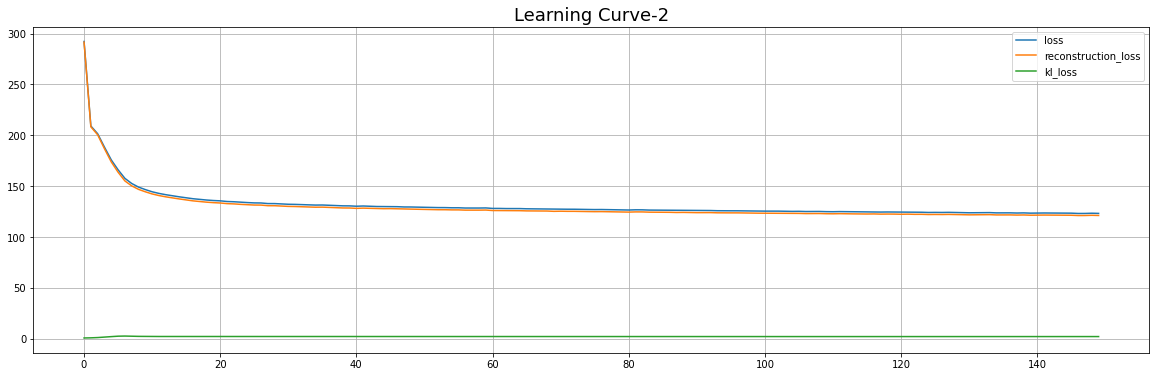

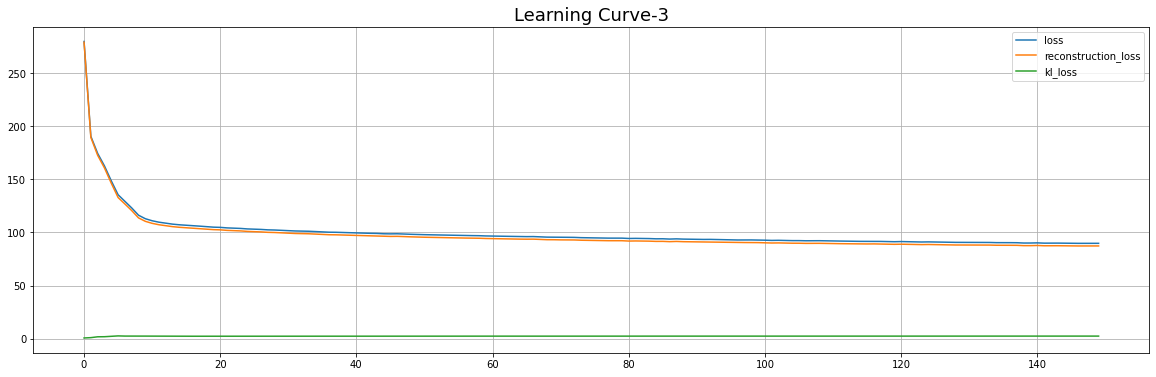

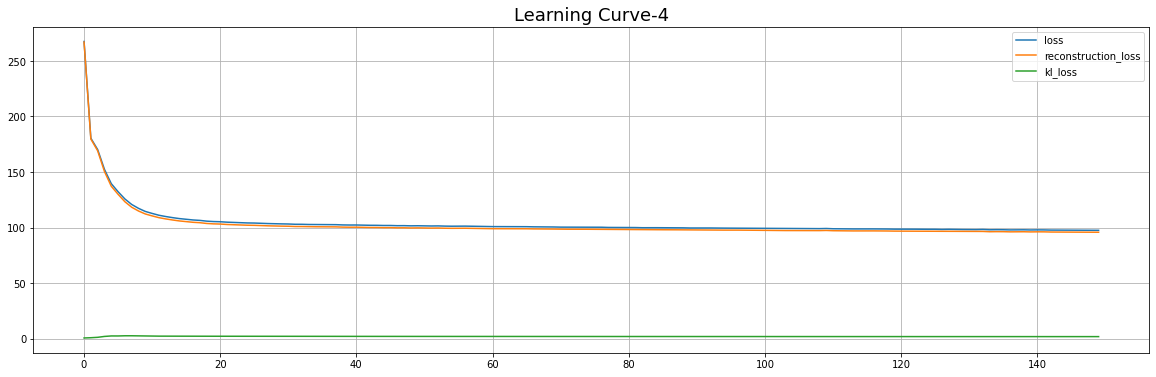

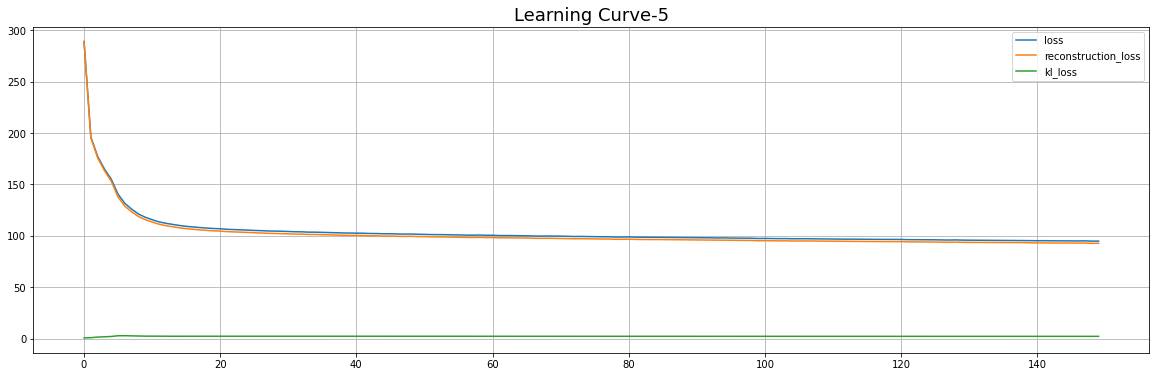

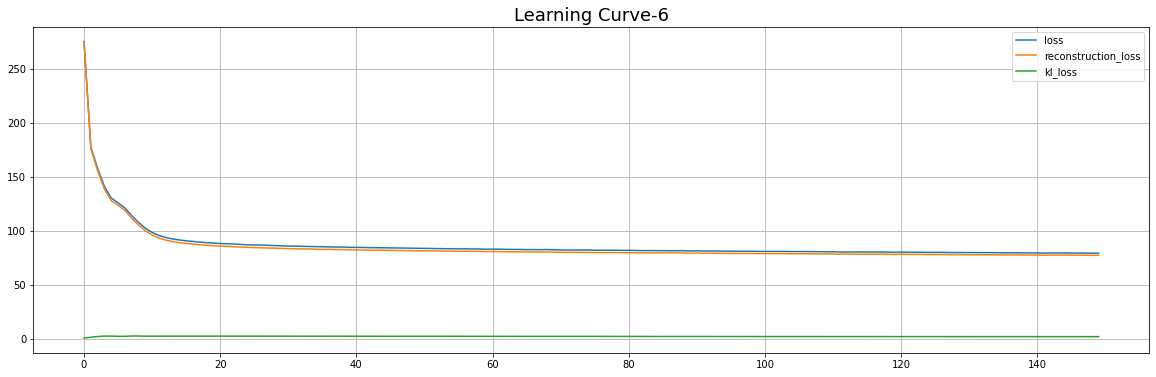

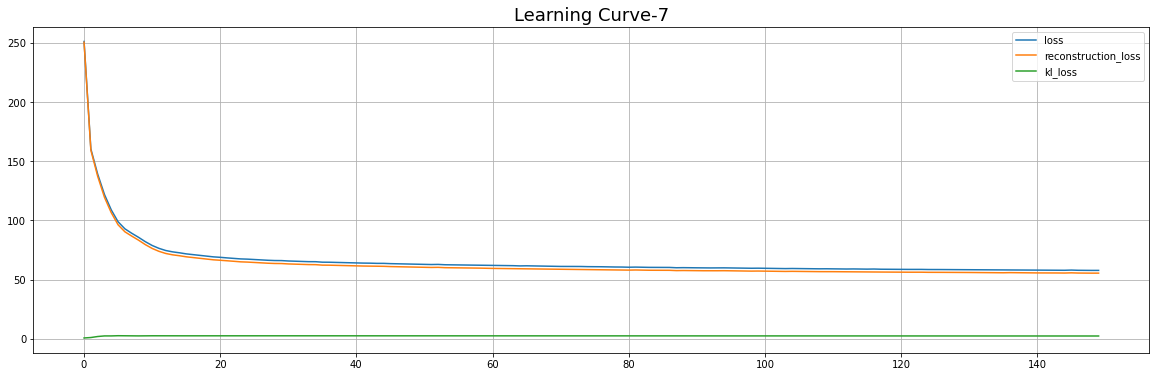

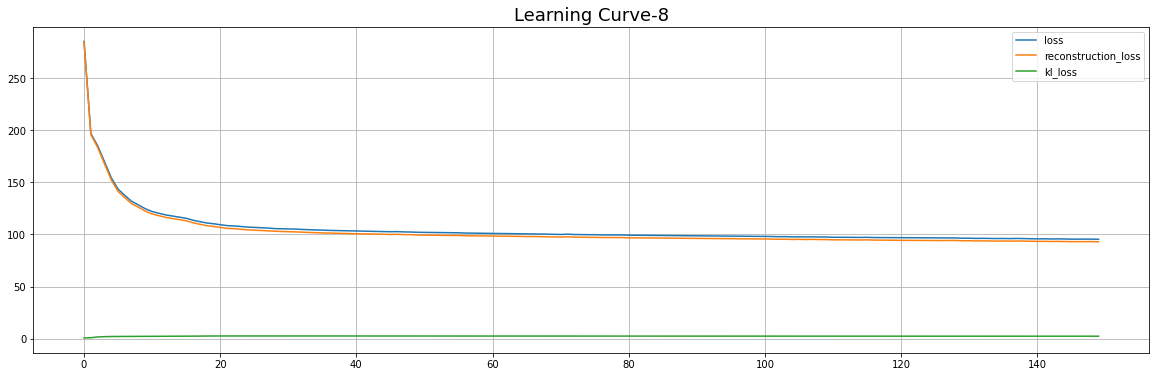

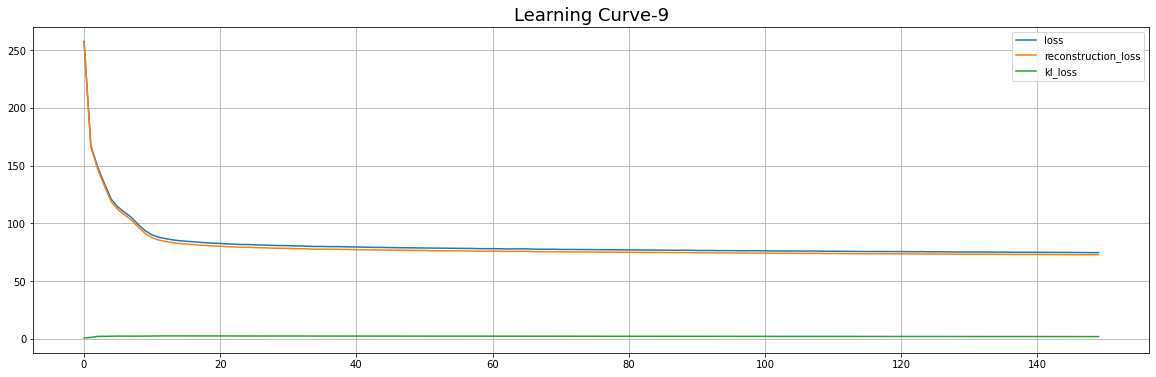

In [10]:
for i in range(10):
    LABEL = i
    dataset = prepare_data(LABEL,BATCH_SIZE)
    
    encoder = build_encoder()
    decoder = build_decoder()
    
    gan = VAE(
    encoder = encoder, decoder=decoder)
    gan.compile(
    keras.optimizers.Adam(learning_rate = 0.001),)
    fig,ax = plt.subplots(figsize=(20,6))
    ax.set_title(f'Learning Curve-{LABEL}',fontsize=18)
    history = gan.fit(dataset,epochs=N_EPOCHS,verbose=1)
    pd.DataFrame(history.history).plot(ax=ax)
    ax.grid()
    
    decoder.save(f'MNIST-AUG-VAE-{LABEL}.h5')

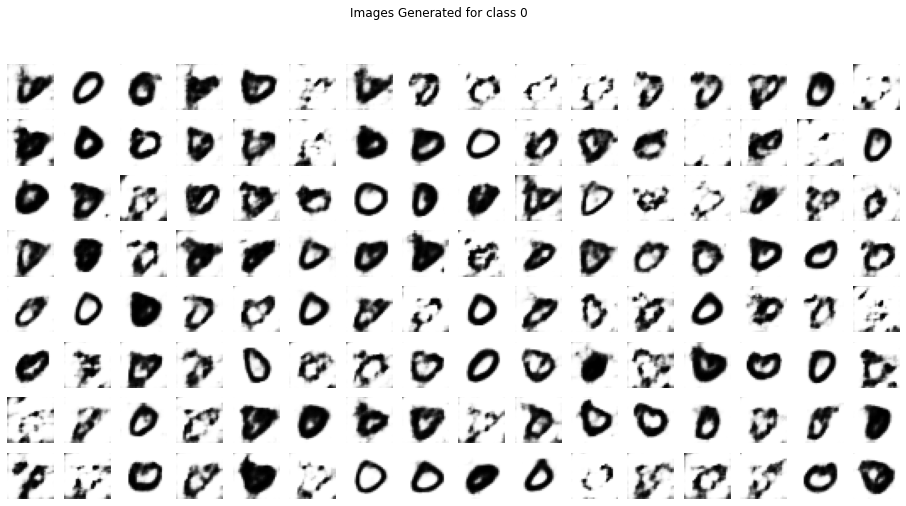

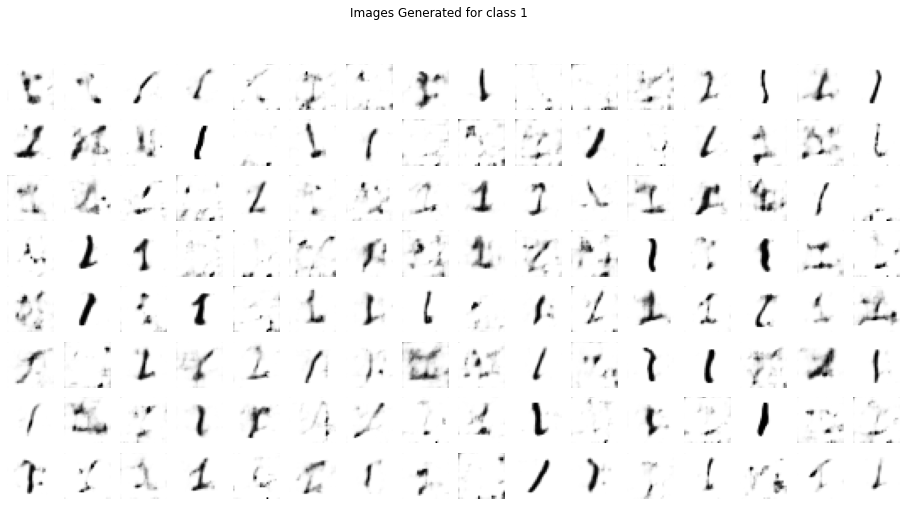

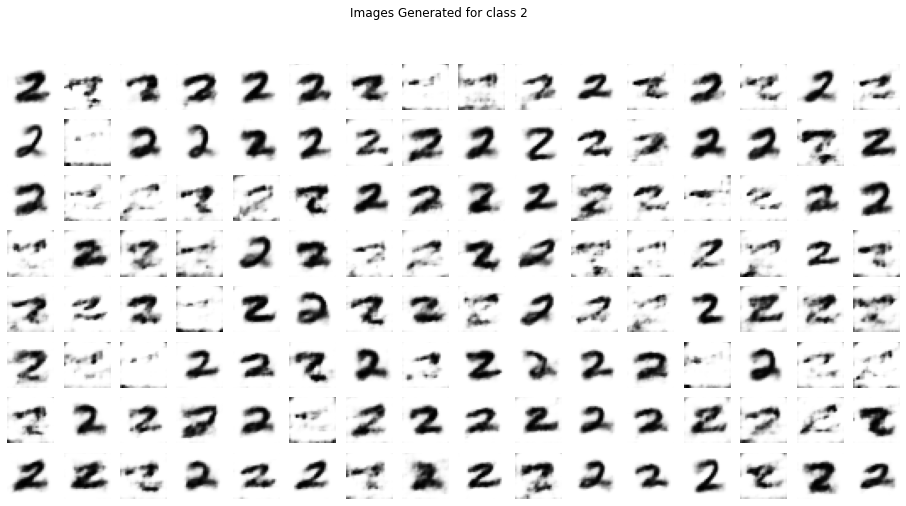

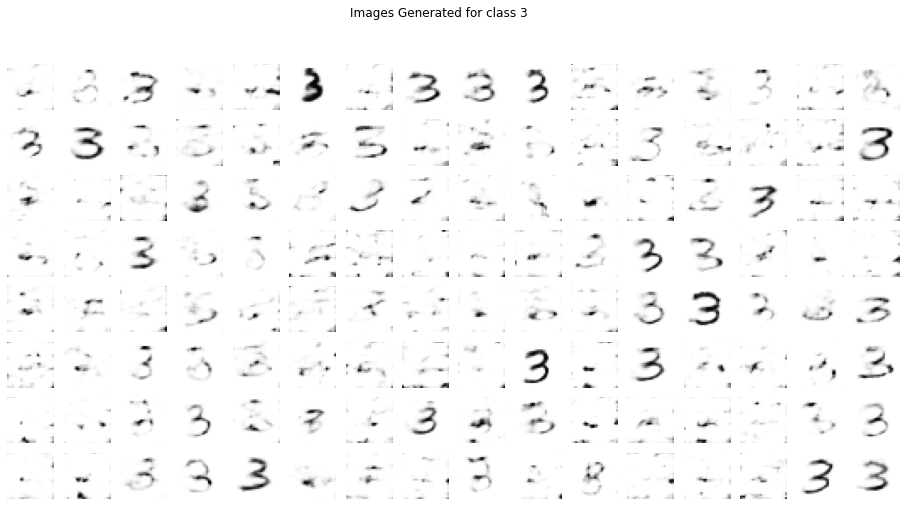

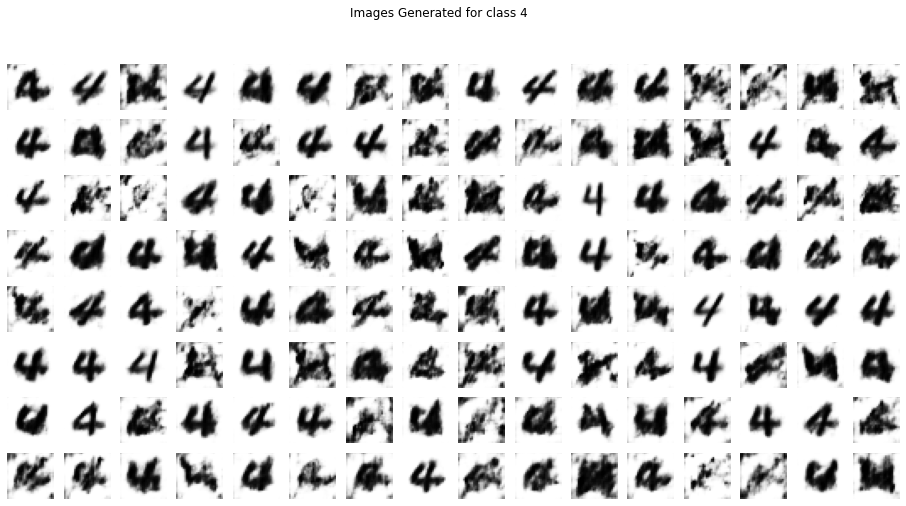

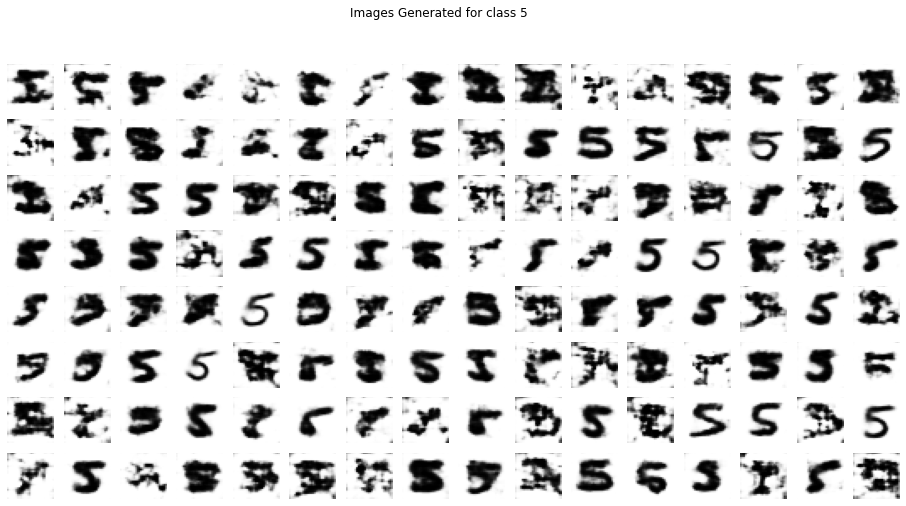

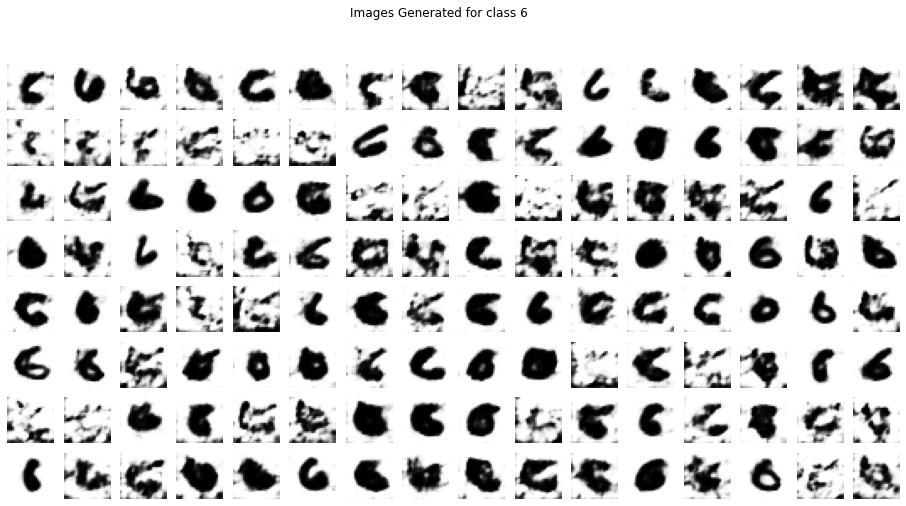

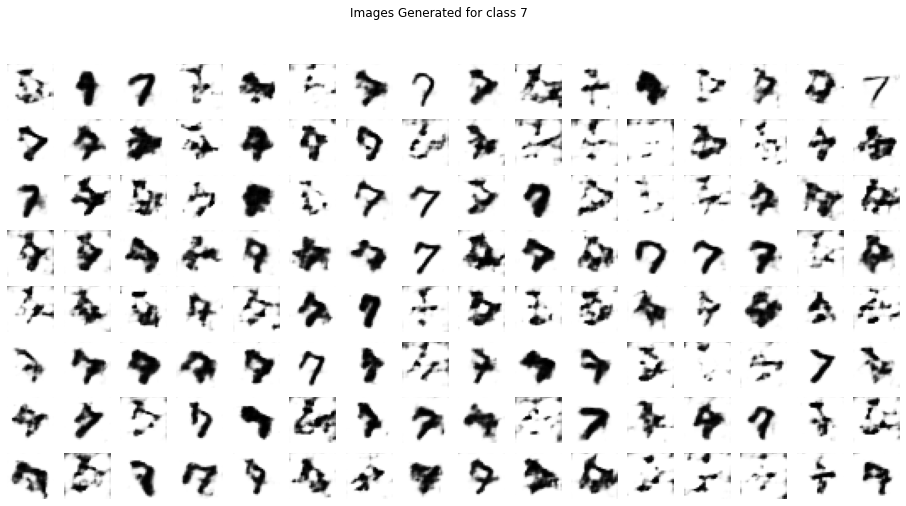

In [ ]:
for i in range(10):
    decoder = keras.models.load_model(f'MNIST-AUG-VAE-{i}.h5')
    fake_images = decoder(tf.random.normal([128,CODINGS_SIZE]))
    plot_results(fake_images,16,f'Images Generated for class {i}')
    plt.show()